In [1]:
import torch , gc
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
import os
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
stats = (0.7964, 0.7694, 0.7826),(0.3202, 0.3362, 0.3384)

In [3]:
image_size = 256
batch_size = 32

In [5]:
train_tfms = T.Compose([T.ToTensor(),T.Normalize(*stats)])
DIR_PATH = 'flower_pattern'
train_ds = ImageFolder(DIR_PATH,transform=train_tfms)
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=3,pin_memory=True)

In [6]:
def denorm(img):
    return img*stats[1][0]+stats[0][0]

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
device = get_default_device()
device

device(type='cuda')

In [9]:
train_dl = DeviceDataLoader(train_dl,device)

In [10]:
discriminator = nn.Sequential(
    #3x256x256
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),
    #64x128x128

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=True),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),
    #128x64x64

    nn.Conv2d(128,128,kernel_size=4,stride=2,padding=1,bias=True),
    nn.LeakyReLU(0.2,inplace=True),
    #128x32x32

    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),
    #256x16x16

    nn.Conv2d(256,256,kernel_size=4,stride=2,padding=1,bias=True),
    nn.LeakyReLU(0.2,inplace=True),
    #256x8x8

    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    #512x4x4

    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
    #1x1x1

    nn.Flatten(),
    nn.Sigmoid()
)

In [11]:
discriminator = to_device(discriminator,device)
discriminator

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (12): LeakyReLU(negative_slope=0.2, inplace=True)
  (13): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [13]:
latent_size = 128

In [15]:
generator = nn.Sequential(
    #latentx1x1
    nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #512x4x4

    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #256x8x8

    nn.ConvTranspose2d(256,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.ReLU(True),
    #256x16x16

    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #128x32x32

    nn.ConvTranspose2d(128,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.ReLU(True),
    #128x64x64

    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=True),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #64x128x128

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    nn.Tanh()
    #3x256x256
)

In [16]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)


torch.Size([32, 3, 256, 256])


In [17]:
generator = to_device(generator,device)
generator

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): ReLU(inplace=True)
  (8): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (12): ReLU(inplace=True)
  (13): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (14): BatchNorm2d(64, eps=1e-05, momentum

In [18]:
def d_train(real_images,opt_d):
    opt_d.zero_grad()

    #pass real
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1,device=device)
    real_loss = F.binary_cross_entropy(real_preds,real_targets)
    real_score = torch.mean(real_preds).item()

    #generate fake_img
    latent = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = generator(latent)

    #passing fake through disc
    fake_targets = torch.zeros(fake_images.size(0),1,device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds,fake_targets)
    fake_score = torch.mean(fake_preds).item()

    #updating disc weights
    loss = real_loss+fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [19]:
def g_train(opt_g):
    opt_g.zero_grad()

    #generate fake img
    latent = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = generator(latent)

    #FOOLING DISCRIMINATOR
    preds = discriminator(fake_images)
    target = torch.ones(batch_size,1,device=device)
    loss = F.binary_cross_entropy(preds,target)

    #updating gene. weights
    loss.backward()
    opt_g.step()
    return loss.item()

In [38]:
# saving images
sample_dir = 'flower_gen'
os.makedirs(sample_dir,exist_ok=True)

In [32]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'gen2-flower-{}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [23]:
fixed_latent = torch.randn(64,latent_size,1,1,device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving gen-flower-0.png


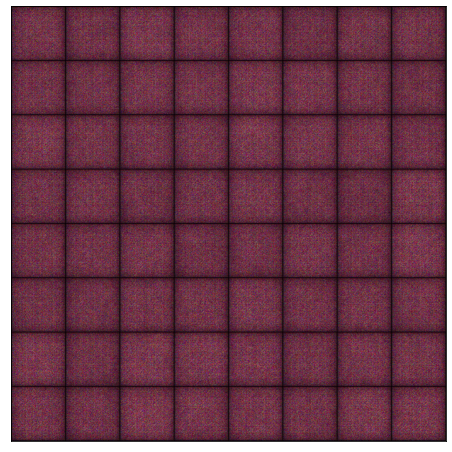

In [24]:
save_samples(0, fixed_latent)

In [34]:
def fit(epochs,lr,start_idx =1):
    gc.collect()
    torch.cuda.empty_cache()

    g_losses = []
    d_losses = []
    real_scores = []
    fake_scores = []

    #optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))
    opt_g = torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))

    for epoch in range(epochs):
        for real_images,_ in tqdm(train_dl):
            #disc train
            loss_d,real_score,fake_score = d_train(real_images,opt_d)
            #train_gen
            loss_g = g_train(opt_g)
        
        g_losses.append(loss_g)
        d_losses.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        #printing
        print("Epoch:",epoch+1," loss_g:",loss_g," loss_d:",loss_d," real_score:",real_score," fake_score:",fake_score)

        #saving
        save_samples(epoch+start_idx, fixed_latent,show=False)

    return g_losses,d_losses,real_scores,fake_scores

In [36]:
epochs = 20
lr = 0.001

In [37]:
his1 = fit(epochs,lr)

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 1  loss_g: 1.4892494678497314  loss_d: 3.2752907276153564  real_score: 0.04986850172281265  fake_score: 0.027371622622013092
Saving gen2-flower-1.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 2  loss_g: 2.191091299057007  loss_d: 2.3336689472198486  real_score: 0.15946760773658752  fake_score: 0.034682322293519974
Saving gen2-flower-2.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 3  loss_g: 2.655174732208252  loss_d: 0.3018016219139099  real_score: 0.859064519405365  fake_score: 0.12828069925308228
Saving gen2-flower-3.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 4  loss_g: 4.26576042175293  loss_d: 2.2905311584472656  real_score: 0.9679703712463379  fake_score: 0.8570170998573303
Saving gen2-flower-4.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 5  loss_g: 5.7904462814331055  loss_d: 0.07859265804290771  real_score: 0.9969008564949036  fake_score: 0.07069354504346848
Saving gen2-flower-5.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 6  loss_g: 8.361093521118164  loss_d: 2.329976797103882  real_score: 0.9900869131088257  fake_score: 0.8359936475753784
Saving gen2-flower-6.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 7  loss_g: 2.4726297855377197  loss_d: 0.5158085227012634  real_score: 0.7119878530502319  fake_score: 0.0737573653459549
Saving gen2-flower-7.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 8  loss_g: 3.182908535003662  loss_d: 0.3207848370075226  real_score: 0.9509239792823792  fake_score: 0.2152959108352661
Saving gen2-flower-8.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 9  loss_g: 3.3021745681762695  loss_d: 0.24761024117469788  real_score: 0.9132336378097534  fake_score: 0.1296272575855255
Saving gen2-flower-9.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 10  loss_g: 2.2970476150512695  loss_d: 0.9399451017379761  real_score: 0.6187103986740112  fake_score: 0.17356228828430176
Saving gen2-flower-10.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 11  loss_g: 2.899888038635254  loss_d: 0.2422546148300171  real_score: 0.9284586310386658  fake_score: 0.10984295606613159
Saving gen2-flower-11.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 12  loss_g: 6.134302139282227  loss_d: 0.07712028175592422  real_score: 0.9510642886161804  fake_score: 0.024633994325995445
Saving gen2-flower-12.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 13  loss_g: 4.626952171325684  loss_d: 0.3860357105731964  real_score: 0.9592124223709106  fake_score: 0.19489704072475433
Saving gen2-flower-13.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 14  loss_g: 3.3236184120178223  loss_d: 0.60038161277771  real_score: 0.6703311800956726  fake_score: 0.020550008863210678
Saving gen2-flower-14.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 15  loss_g: 4.749732971191406  loss_d: 0.5454856157302856  real_score: 0.9990137219429016  fake_score: 0.34769630432128906
Saving gen2-flower-15.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 16  loss_g: 5.715564250946045  loss_d: 0.548075795173645  real_score: 0.9860616326332092  fake_score: 0.33630454540252686
Saving gen2-flower-16.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 17  loss_g: 3.006850242614746  loss_d: 0.20707564055919647  real_score: 0.8965674638748169  fake_score: 0.05049800127744675
Saving gen2-flower-17.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 18  loss_g: 6.216159343719482  loss_d: 0.10546309500932693  real_score: 0.9526776075363159  fake_score: 0.034818265587091446
Saving gen2-flower-18.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 19  loss_g: 1.9009621143341064  loss_d: 0.4784276485443115  real_score: 0.7648472785949707  fake_score: 0.07655332237482071
Saving gen2-flower-19.png


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch: 20  loss_g: 7.479677200317383  loss_d: 0.2760917544364929  real_score: 0.979631245136261  fake_score: 0.14608147740364075
Saving gen2-flower-20.png


In [65]:
import cv2
import os

vid_fname = 'flower_train2.mp4'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if '1' in f]
files.sort()
frame = cv2.imread("flower_gen/1.png")

height, width, layers = frame.shape

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'mp4v'), 0,1, (width,height))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [63]:
import cv2
import os
# import sys 

# sys.path.append('/usr/local/lib/python3.9/site-packages')

frame = cv2.imread("flower_gen/1.png")

height, width, layers = frame.shape

  
video = cv2.VideoWriter("./FlowerGANS.avi",cv2.VideoWriter_fourcc(*'MJPG'), 0, 1, (width, height)) 

images = os.listdir("flower_gen")

for image in images:
   frame = cv2.resize(frame, (height, width))
   video.write(cv2.imread("flower_gen"+image)) 
      
cv2.destroyAllWindows() 
video.release()